# Swimming Pool Detection

In [3]:
# Notebook Configuration

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from ds_code_challenge.data.image_loader import load_swimming_pool_dataset, PoolDataset
from ds_code_challenge.modeling import PoolDetector, train_pool_detector, predict_image
from ds_code_challenge.config import Config

import sys
import logging
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch
import seaborn as sns
import random

## Load and Explore Data

In [5]:
data_dir = Config.DATA_DIR / 'raw' / 'images' / 'swimming-pool'

train_loader, test_loader, class_names = load_swimming_pool_dataset(
    data_dir=data_dir,
    image_size=224,
    batch_size=32,
    test_size=0.2,
    random_state=42
)

INFO:ds_code_challenge.data.image_loader:Loading dataset from /Users/wiebke/PycharmProjects/ds_code_challenge/data/raw/images/swimming-pool
INFO:ds_code_challenge.data.image_loader:Found 1000 images with pools (from directory)
INFO:ds_code_challenge.data.image_loader:Found 1000 images without pools (from directory)
INFO:ds_code_challenge.data.image_loader:Loaded 2000 images total
INFO:ds_code_challenge.data.image_loader:  With pool: 1000
INFO:ds_code_challenge.data.image_loader:  Without pool: 1000
INFO:ds_code_challenge.data.image_loader:Train set: 1600 images
INFO:ds_code_challenge.data.image_loader:Test set: 400 images


2025-10-20 12:02:24.878 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge
2025-10-20 12:02:24.878 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge


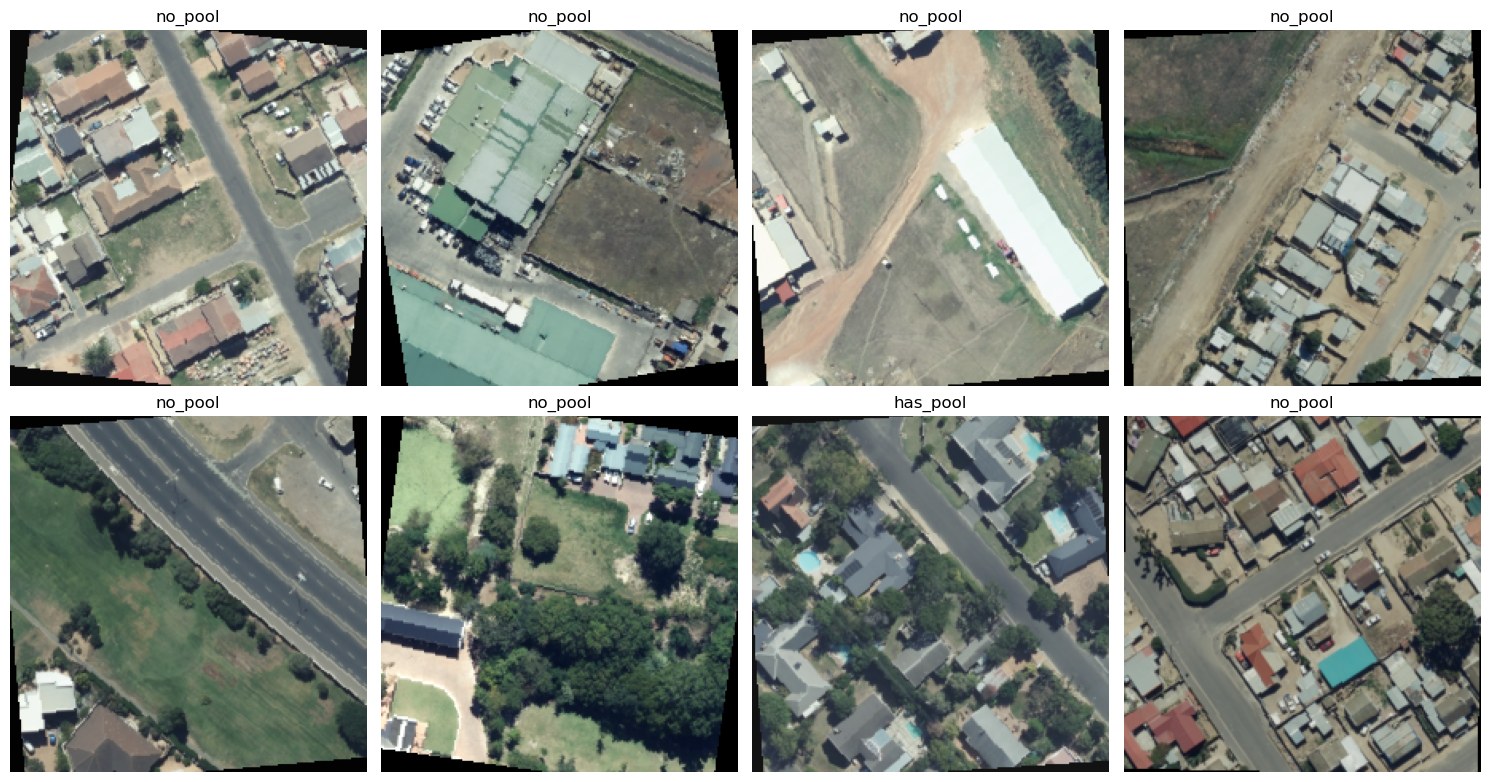

In [6]:
# Get a batch of training data
images, labels = next(iter(train_loader))

# Denormalize for visualization
def denormalize(tensor):
    """Denormalize image tensor for visualization."""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return tensor * std + mean

# Plot sample images
fig, axes = plt.subplots(2, 4, figsize=(15, 8))
axes = axes.flatten()

for i in range(8):
    img = denormalize(images[i])
    img = img.permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    
    axes[i].imshow(img)
    axes[i].set_title(f"{class_names[labels[i].item()]}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## Create and Train Model

In [6]:
# Create model
detector = PoolDetector()

# Print model architecture
print("\nModel Architecture:")
print(detector.model)

# Count parameters
total_params = sum(p.numel() for p in detector.model.parameters())
trainable_params = sum(p.numel() for p in detector.model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

INFO:ds_code_challenge.modeling.pool_detector:Using device: cpu
INFO:ds_code_challenge.modeling.pool_detector:Model created with 3,267,713 parameters



Model Architecture:
SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

Total parameters: 3,267,713
Trainable parameters: 3,267,713


In [7]:
# Train model

history = detector.train(
    train_loader=train_loader,
    val_loader=test_loader,
    epochs=20,
    lr=0.001
)

INFO:ds_code_challenge.modeling.pool_detector:Starting training for 20 epochs
INFO:ds_code_challenge.modeling.pool_detector:Learning rate: 0.001


2025-10-20 10:54:36.432 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge
2025-10-20 10:54:36.432 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge
2025-10-20 10:55:37.916 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge
2025-10-20 10:55:37.916 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge


INFO:ds_code_challenge.modeling.pool_detector:Epoch [1/20] Train Loss: 0.6208, Train Acc: 0.6531 | Val Loss: 0.6100, Val Acc: 0.5625


2025-10-20 10:55:56.363 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge
2025-10-20 10:55:56.363 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge
2025-10-20 10:57:01.972 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge
2025-10-20 10:57:01.972 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge


INFO:ds_code_challenge.modeling.pool_detector:Epoch [2/20] Train Loss: 0.5131, Train Acc: 0.7544 | Val Loss: 0.4584, Val Acc: 0.7650


2025-10-20 10:57:20.022 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge
2025-10-20 10:57:20.022 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge
2025-10-20 10:58:19.631 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge
2025-10-20 10:58:19.631 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge


INFO:ds_code_challenge.modeling.pool_detector:Epoch [3/20] Train Loss: 0.5111, Train Acc: 0.7688 | Val Loss: 0.4502, Val Acc: 0.7825


2025-10-20 10:58:39.047 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge
2025-10-20 10:58:39.047 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge
2025-10-20 10:59:42.607 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge
2025-10-20 10:59:42.606 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge


INFO:ds_code_challenge.modeling.pool_detector:Epoch [4/20] Train Loss: 0.4939, Train Acc: 0.7638 | Val Loss: 0.4213, Val Acc: 0.8100


2025-10-20 11:00:00.775 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge
2025-10-20 11:00:00.775 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge
2025-10-20 11:01:05.825 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge
2025-10-20 11:01:05.825 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge


INFO:ds_code_challenge.modeling.pool_detector:Epoch [5/20] Train Loss: 0.4916, Train Acc: 0.7831 | Val Loss: 0.4622, Val Acc: 0.7800


2025-10-20 11:01:24.120 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge
2025-10-20 11:01:24.120 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge
2025-10-20 11:02:36.053 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge
2025-10-20 11:02:36.053 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge


INFO:ds_code_challenge.modeling.pool_detector:Epoch [6/20] Train Loss: 0.4608, Train Acc: 0.7994 | Val Loss: 0.4014, Val Acc: 0.8175


2025-10-20 11:02:54.732 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge
2025-10-20 11:02:54.732 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge
2025-10-20 11:04:04.270 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge
2025-10-20 11:04:04.270 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge


INFO:ds_code_challenge.modeling.pool_detector:Epoch [7/20] Train Loss: 0.4319, Train Acc: 0.8125 | Val Loss: 0.4309, Val Acc: 0.7775


2025-10-20 11:04:24.249 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge
2025-10-20 11:04:24.249 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge
2025-10-20 11:05:31.192 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge
2025-10-20 11:05:31.192 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge


INFO:ds_code_challenge.modeling.pool_detector:Epoch [8/20] Train Loss: 0.4150, Train Acc: 0.8256 | Val Loss: 0.3662, Val Acc: 0.8275


2025-10-20 11:05:50.480 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge
2025-10-20 11:05:50.480 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge
2025-10-20 11:06:57.637 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge
2025-10-20 11:06:57.637 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge


INFO:ds_code_challenge.modeling.pool_detector:Epoch [9/20] Train Loss: 0.4692, Train Acc: 0.8275 | Val Loss: 0.4228, Val Acc: 0.7975


2025-10-20 11:07:15.825 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge
2025-10-20 11:07:15.825 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge
2025-10-20 11:08:25.302 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge
2025-10-20 11:08:25.302 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge


INFO:ds_code_challenge.modeling.pool_detector:Epoch [10/20] Train Loss: 0.4352, Train Acc: 0.8387 | Val Loss: 0.3556, Val Acc: 0.8300


2025-10-20 11:08:46.678 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge
2025-10-20 11:08:46.679 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge
2025-10-20 11:09:55.083 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge
2025-10-20 11:09:55.084 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge


INFO:ds_code_challenge.modeling.pool_detector:Epoch [11/20] Train Loss: 0.3596, Train Acc: 0.8462 | Val Loss: 0.3265, Val Acc: 0.8550


2025-10-20 11:10:13.777 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge
2025-10-20 11:10:13.777 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge
2025-10-20 11:11:19.904 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge
2025-10-20 11:11:19.904 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge


INFO:ds_code_challenge.modeling.pool_detector:Epoch [12/20] Train Loss: 0.4232, Train Acc: 0.8456 | Val Loss: 0.3371, Val Acc: 0.8500


2025-10-20 11:11:39.080 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge
2025-10-20 11:11:39.080 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge
2025-10-20 11:12:46.016 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge
2025-10-20 11:12:46.016 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge


INFO:ds_code_challenge.modeling.pool_detector:Epoch [13/20] Train Loss: 0.3639, Train Acc: 0.8744 | Val Loss: 0.2783, Val Acc: 0.8650


2025-10-20 11:13:14.459 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge
2025-10-20 11:13:14.459 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge
2025-10-20 11:14:51.998 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge
2025-10-20 11:14:51.998 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge


INFO:ds_code_challenge.modeling.pool_detector:Epoch [14/20] Train Loss: 0.2887, Train Acc: 0.8825 | Val Loss: 0.2585, Val Acc: 0.8875


2025-10-20 11:15:16.188 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge
2025-10-20 11:15:16.188 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge
2025-10-20 11:16:49.287 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge
2025-10-20 11:16:49.287 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge


INFO:ds_code_challenge.modeling.pool_detector:Epoch [15/20] Train Loss: 0.4287, Train Acc: 0.9019 | Val Loss: 0.2771, Val Acc: 0.8975


2025-10-20 11:17:08.888 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge
2025-10-20 11:17:08.888 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge
2025-10-20 11:18:37.694 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge
2025-10-20 11:18:37.694 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge


INFO:ds_code_challenge.modeling.pool_detector:Epoch [16/20] Train Loss: 0.2812, Train Acc: 0.8906 | Val Loss: 0.1987, Val Acc: 0.9125


2025-10-20 11:18:57.611 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge
2025-10-20 11:18:57.611 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge
2025-10-20 11:20:23.900 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge
2025-10-20 11:20:23.900 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge


INFO:ds_code_challenge.modeling.pool_detector:Epoch [17/20] Train Loss: 0.2628, Train Acc: 0.9213 | Val Loss: 0.1976, Val Acc: 0.9150


2025-10-20 11:20:42.817 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge
2025-10-20 11:20:42.817 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge
2025-10-20 11:22:09.718 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge
2025-10-20 11:22:09.718 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge


INFO:ds_code_challenge.modeling.pool_detector:Epoch [18/20] Train Loss: 0.2470, Train Acc: 0.9300 | Val Loss: 0.1722, Val Acc: 0.9350


2025-10-20 11:22:28.353 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge
2025-10-20 11:22:28.353 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge
2025-10-20 11:23:48.842 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge
2025-10-20 11:23:48.842 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge


INFO:ds_code_challenge.modeling.pool_detector:Epoch [19/20] Train Loss: 0.2517, Train Acc: 0.9337 | Val Loss: 0.2572, Val Acc: 0.9125


2025-10-20 11:24:07.697 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge
2025-10-20 11:24:07.697 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge
2025-10-20 11:25:30.046 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge
2025-10-20 11:25:30.046 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge


INFO:ds_code_challenge.modeling.pool_detector:Epoch [20/20] Train Loss: 0.2314, Train Acc: 0.9419 | Val Loss: 0.1972, Val Acc: 0.9175
INFO:ds_code_challenge.modeling.pool_detector:✓ Training complete


In [ ]:
model_dir = Config.MODELS_DIR / 'simple_cnn__swimming-pool__valacc_91.2__2025-10-20'
detector.save(model_dir)

## Evaluate Model

In [16]:
# Evaluate on Test Set

results = detector.evaluate(test_loader)

print(f"\nTest Accuracy: {results['accuracy']:.4f}")
print(f"Test Precision: {results['precision']:.4f}")
print(f"Test Recall: {results['recall']:.4f}")
print(f"Test F1 Score: {results['f1']:.4f}")

INFO:ds_code_challenge.modeling.pool_detector:Evaluating model
python(11081) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(11082) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


2025-10-20 11:29:30.110 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge
2025-10-20 11:29:30.110 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge


INFO:ds_code_challenge.modeling.pool_detector:Accuracy:  0.9175
INFO:ds_code_challenge.modeling.pool_detector:Precision: 0.9154
INFO:ds_code_challenge.modeling.pool_detector:Recall:    0.9200
INFO:ds_code_challenge.modeling.pool_detector:F1 Score:  0.9177
INFO:ds_code_challenge.modeling.pool_detector:
Confusion Matrix:
[[183  17]
 [ 16 184]]



Test Accuracy: 0.9175
Test Precision: 0.9154
Test Recall: 0.9200
Test F1 Score: 0.9177


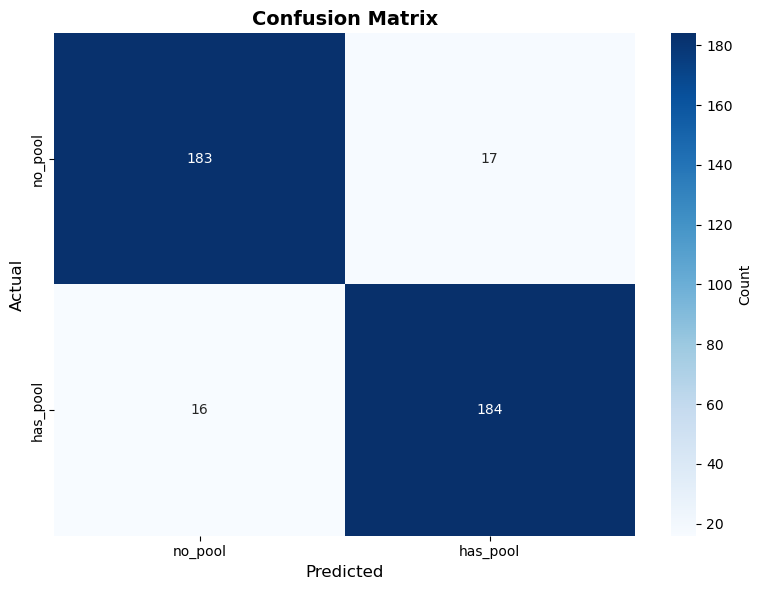

In [17]:
# Visualise Confusion Matrix

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    results['confusion_matrix'],
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names,
    ax=ax,
    cbar_kws={'label': 'Count'}
)
ax.set_title('Confusion Matrix', fontsize=14, fontweight='bold')
ax.set_xlabel('Predicted', fontsize=12)
ax.set_ylabel('Actual', fontsize=12)
plt.tight_layout()
plt.show()

python(11116) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(11117) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


2025-10-20 11:31:40.495 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge
2025-10-20 11:31:40.495 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge


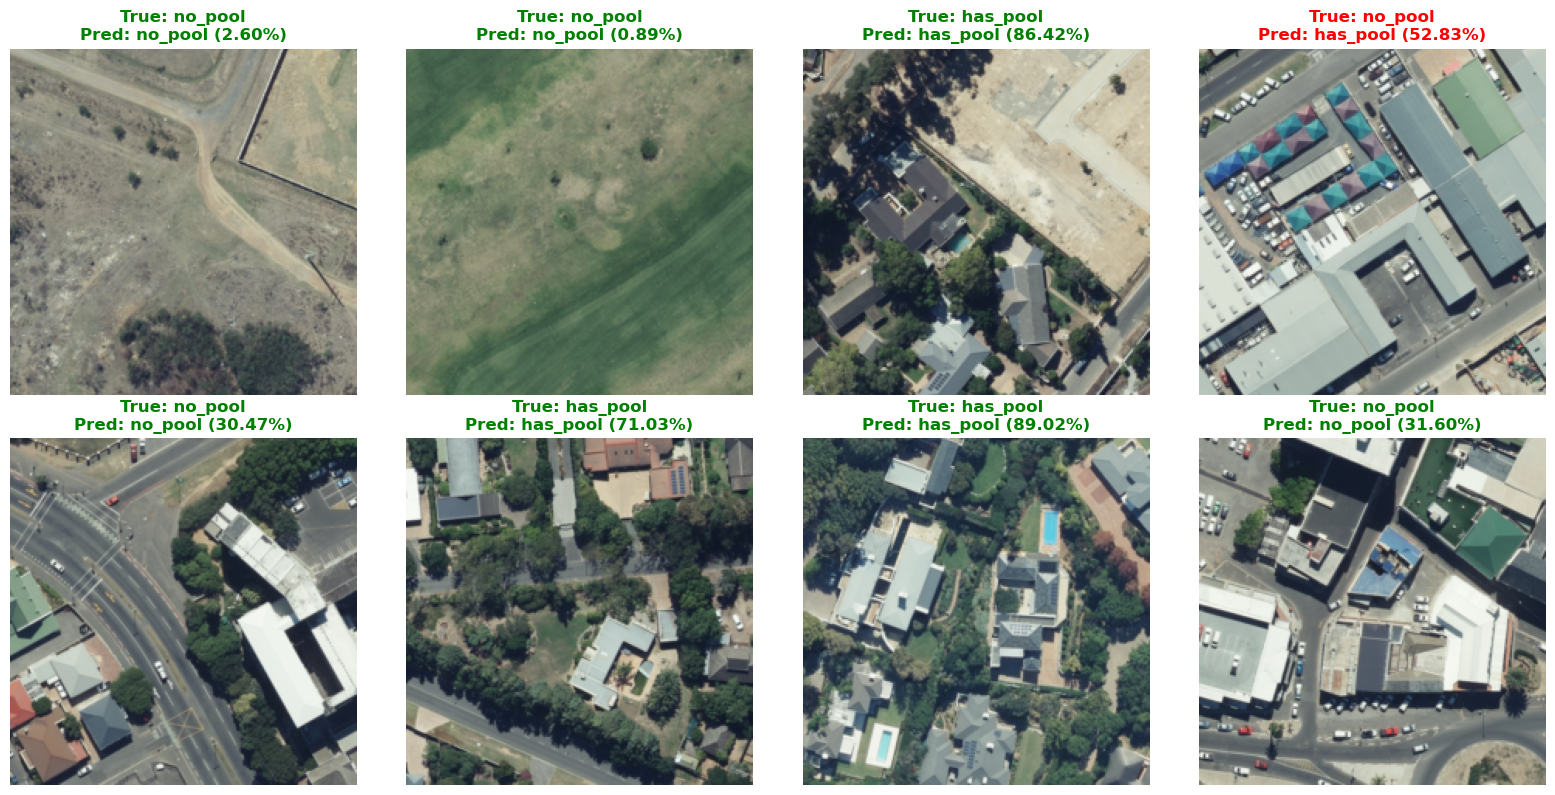

In [18]:
# Visualise Predictions

# Get a batch from test set
test_images, test_labels = next(iter(test_loader))

# Make predictions
detector.model.eval()
with torch.no_grad():
    test_images_device = test_images.to(detector.device)
    outputs = detector.model(test_images_device)
    predictions = (outputs > 0.5).float().cpu().numpy().flatten()
    probabilities = outputs.cpu().numpy().flatten()

# Plot predictions
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i in range(8):
    img = denormalize(test_images[i])
    img = img.permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    
    true_label = class_names[test_labels[i].item()]
    pred_label = class_names[int(predictions[i])]
    confidence = probabilities[i]
    
    # Color: green if correct, red if incorrect
    color = 'green' if predictions[i] == test_labels[i].item() else 'red'
    
    axes[i].imshow(img)
    axes[i].set_title(
        f"True: {true_label}\nPred: {pred_label} ({confidence:.2%})",
        color=color,
        fontweight='bold'
    )
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## Analyse Errors

In [19]:
# Get all predictions and labels
all_preds = results['predictions']
all_labels = []
for _, labels in test_loader:
    all_labels.extend(labels.numpy())
all_labels = np.array(all_labels)

# Find misclassified examples
errors = np.where(all_preds != all_labels)[0]
print(f"\nTotal errors: {len(errors)} out of {len(all_labels)}")

# Breakdown of errors
false_positives = np.where((all_preds == 1) & (all_labels == 0))[0]
false_negatives = np.where((all_preds == 0) & (all_labels == 1))[0]

print(f"False Positives (predicted pool, no pool): {len(false_positives)}")
print(f"False Negatives (predicted no pool, has pool): {len(false_negatives)}")

python(11120) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(11121) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


2025-10-20 11:32:37.141 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge
2025-10-20 11:32:37.141 | INFO     | ds_code_challenge.config:Config:26 - PROJ_ROOT path is: /Users/wiebke/PycharmProjects/ds_code_challenge

Total errors: 33 out of 400
False Positives (predicted pool, no pool): 17
False Negatives (predicted no pool, has pool): 16


## Load and Test Saved Model

In [14]:
# Load model
loaded_detector = PoolDetector.load(model_dir)

# Test on same image
test_img = test_images_paths[0]
prediction, probability = loaded_detector.predict(test_img)

print(f"Loaded model prediction: {class_names[prediction]} ({probability:.2%})")
print("Model loaded successfully")

INFO:ds_code_challenge.modeling.pool_detector:Using device: cpu
INFO:ds_code_challenge.modeling.pool_detector:Model created with 3,267,713 parameters
INFO:ds_code_challenge.modeling.pool_detector:Model loaded from /Users/wiebke/PycharmProjects/ds_code_challenge/models/simple_cnn__swimming-pool__valacc_91.2__2025-10-20/pool_detector.pth


Loaded model prediction: has_pool (99.99%)
Model loaded successfully
